# Embedding space analysis

The goal here is to analyze the embedding space of trained models. 

We will visualize the embeddings of the words in the vocabulary, and also the embedding of the titles.

I hope that using UMAP, we can see some interesting clusters in the embedding space.

Also, thanks to cosine similarity, we will create a recommendation system based on the embeddings.

In [1]:

import torch
from classifier.article_dataset import ArticleDataset
from torch.utils.data import DataLoader
from classifier.models.mlp_classifier import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('../classifier')  # Add parent directory to Python path
from utils import custom_collate
from models.mlp_classifier import MLPClassifier
from models.bilstm_classifier import BiLSTMClassifier
from models.bilstmattention_classifier import BiLSTMAttentionClassifier

In [3]:
folder = "mlp"
experiment_name = "mlp_title_fulldb"
checkpoint_path = os.path.join('..', 'classifier', 'experiments', folder, experiment_name, f'{experiment_name}.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(checkpoint_path, map_location=device)
hparams = checkpoint['hyperparameters']
checkpoint.keys(), hparams.keys()

(dict_keys(['model_state_dict', 'hyperparameters', 'dataset_filters']),
 dict_keys(['vocab_size', 'embedding_dim', 'hidden_dim', 'num_classes', 'num_hidden_layers', 'dropout', 'freeze_embeddings']))

In [4]:
model_mlp_cat_title = MLPClassifier(
    vocab_size=hparams['vocab_size'],
    embedding_dim=hparams['embedding_dim'],
    hidden_dim=hparams['hidden_dim'],
    num_classes=hparams['num_classes'],
    num_hidden_layers=hparams['num_hidden_layers'],
    dropout=hparams['dropout']
).to(device)

model_mlp_cat_title.load_state_dict(checkpoint['model_state_dict'])
model_mlp_cat_title.eval()

MLPClassifier(
  (embedding): Embedding(38894, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (input_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=20, bias=True)
)

In [5]:
csv_file = "../classifier/data/articles.csv"
use_summary = False  
classification_level = "category"  # ou "sub_category"
selected_categories = None  # ou None pour toutes les catégories

dataset_mlp_cat_title = ArticleDataset(csv_file, use_summary=use_summary,
                         classification_level=classification_level,
                         selected_categories=selected_categories)
# appliquer mêmes filtres
filters = checkpoint.get('dataset_filters', {"min_freq": 5})
dataset_mlp_cat_title.apply_filters(filters)

# découpe train/test si nécessaire, mais ici on utilise tout pour inférence
test_loader = DataLoader(dataset_mlp_cat_title, batch_size=64, collate_fn=custom_collate)

In [6]:
emb = model_mlp_cat_title.embedding.weight.detach()

## OUTDATED PCA - skip

In [7]:
# Let's first perform a PCA before ressorting to better visualizations

emb = model.embedding.weight.detach()
pca = PCA(n_components=2)
reduced_emb = pca.fit_transform(emb.cpu().numpy())

plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], alpha=0.5)
plt.title("PCA Projection of Embeddings")
plt.show()

NameError: name 'model' is not defined

In [ ]:
def get_word_from_coordonates(coordonates, points):
    distances = ((points - coordonates)**2).sum(axis=1)**0.5
    closest_idx = distances.argmin()
    return dataset.index_to_word[closest_idx]

coordonates = [-15,-15]
word = get_word_from_coordonates(coordonates, reduced_emb)
print(f"closest point to {coordonates} is {word}")

closest point to [-15, -15] is narrating


In [ ]:
# Vertical 
x = np.linspace(0, 0, 20)
y = np.linspace(-10, 15, 20)

for x,y in zip(x,y):
    coord = [x,y]
    word = get_word_from_coordonates(coord, reduced_emb)
    print(f"closest point to {x.item(),y.item()} is {word}")

closest point to (0.0, -10.0) is ultracompact
closest point to (0.0, -8.68421052631579) is ultracompact
closest point to (0.0, -7.368421052631579) is n2edm
closest point to (0.0, -6.052631578947368) is defied
closest point to (0.0, -4.7368421052631575) is korn
closest point to (0.0, -3.421052631578947) is detuning
closest point to (0.0, -2.1052631578947363) is believable
closest point to (0.0, -0.7894736842105257) is semiconvexity
closest point to (0.0, 0.526315789473685) is sungrazing
closest point to (0.0, 1.8421052631578956) is tarsi
closest point to (0.0, 3.157894736842106) is 100nm
closest point to (0.0, 4.473684210526317) is 3783
closest point to (0.0, 5.789473684210527) is krause
closest point to (0.0, 7.10526315789474) is hyperpolarizability
closest point to (0.0, 8.421052631578949) is pp
closest point to (0.0, 9.736842105263158) is voigt
closest point to (0.0, 11.05263157894737) is xas
closest point to (0.0, 12.368421052631582) is ruo
closest point to (0.0, 13.684210526315791)

On n'a pas l'impression qu'il y ai de logique dans la proximité des mots.

On va essayer de les traverser horizontallement. 

In [ ]:
# horizontal 
x = np.linspace(-15, 5, 20)
y = np.linspace(1, 1, 20)

for x,y in zip(x,y):
    coord = [x,y]
    word = get_word_from_coordonates(coord, reduced_emb)
    print(f"closest point to {x.item(),y.item()} is {word}")

closest point to (-15.0, 1.0) is cherkis
closest point to (-13.947368421052632, 1.0) is jucys
closest point to (-12.894736842105264, 1.0) is physisorbed
closest point to (-11.842105263157894, 1.0) is cerf
closest point to (-10.789473684210527, 1.0) is comonad
closest point to (-9.736842105263158, 1.0) is jordanian
closest point to (-8.68421052631579, 1.0) is symmetrised
closest point to (-7.631578947368421, 1.0) is loxodromic
closest point to (-6.578947368421053, 1.0) is lithosphere
closest point to (-5.526315789473685, 1.0) is skeletally
closest point to (-4.473684210526317, 1.0) is manoeuvres
closest point to (-3.4210526315789487, 1.0) is cads
closest point to (-2.3684210526315788, 1.0) is muram
closest point to (-1.3157894736842106, 1.0) is sdh
closest point to (-0.2631578947368425, 1.0) is multiflows
closest point to (0.7894736842105257, 1.0) is advancing
closest point to (1.8421052631578938, 1.0) is 1700
closest point to (2.8947368421052637, 1.0) is rossi
closest point to (3.94736

On ne gagne pas beaucoup d'information avec l'acp passons à umap. 

## UMAP on words

In [8]:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)
umap_emb = reducer.fit_transform(emb.cpu().numpy())

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


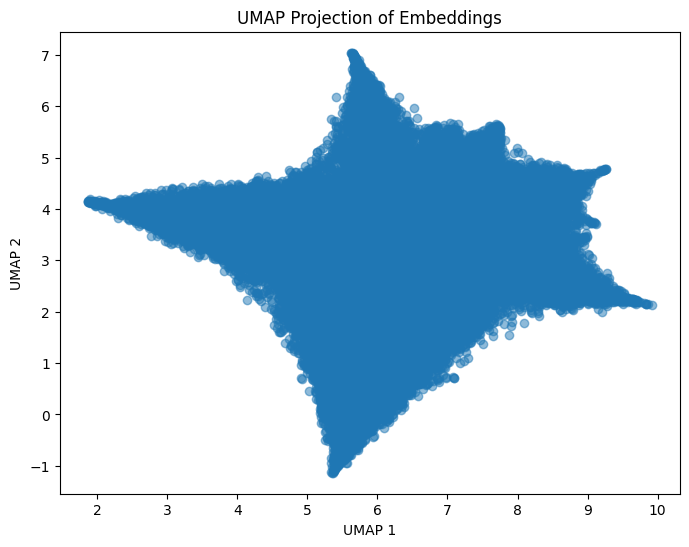

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], alpha=0.5)
plt.title("UMAP Projection of Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

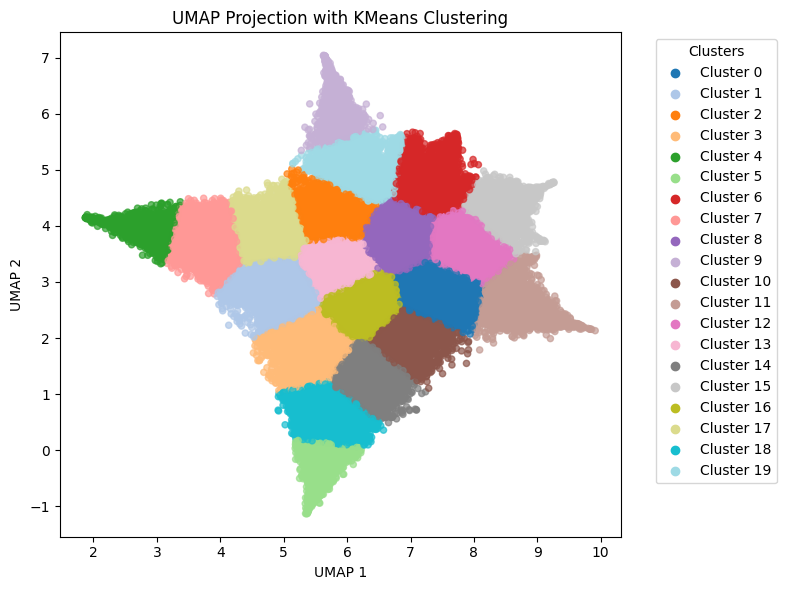

In [10]:

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(umap_emb)

cmap = plt.get_cmap('tab20', n_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(
    umap_emb[:, 0], umap_emb[:, 1],
    c=clusters,
    cmap=cmap,
    vmin=0,
    vmax=n_clusters-1,
    s=20,
    alpha=0.7
)
plt.title("UMAP Projection with KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Légende
unique_clusters = np.unique(clusters)
colors = cmap(np.arange(n_clusters))
for i, uc in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f"Cluster {uc}")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [11]:

for cl in unique_clusters:
    cluster_indices = np.where(clusters == cl)[0] # returns the indices (from clusters) that correspond to the current cluster
    words = [dataset_mlp_cat_title.index_to_word[idx] for idx in cluster_indices[:20]]
    print(f"Cluster {cl}: {', '.join(words)}")

Cluster 0: coexistence, edges, 1d, model, unveiling, nature, relaxation, structural, calculation, body, localization, interaction, correlated, range, based, les, networks, crossover, field, ansatz
Cluster 1: distinct, quadratic, when, block, correspondence, zero, operator, suspension, coefficient, global, contact, applications, higher, 2d, stabilization, under, nelson, manifold, fields, limits
Cluster 2: and, free, theoretical, high, extreme, dynamical, density, first, optimization, mirror, inside, mixture, population, dimensions, varying, pluripotent, dependent, soft, lattices, multifield
Cluster 3: embedding, lectures, graph, layer, edge, me, parallel, combinatorial, graphs, calculus, effective, core, width, sequence, capability, dense, positional, covering, investigating, ordered
Cluster 4: estimates, fibrations, phaseless, injectivity, compactness, derivations, brownian, inequalities, kms, automorphisms, fillings, erd, localizations, digraphs, subcritical, compactly, mazur, cr, bou

In [12]:
# Pour chaque cluster, afficher 20 mots tirés aléatoirement
np.random.seed(42)  # pour reproductibilité
for cl in unique_clusters:
    cluster_indices = np.where(clusters == cl)[0]
    if len(cluster_indices) == 0:
        continue
    sample_size = min(20, len(cluster_indices))
    sampled_indices = np.random.choice(cluster_indices, size=sample_size, replace=False)
    words = [dataset_mlp_cat_title.index_to_word[idx] for idx in sampled_indices]
    print(f"Cluster {cl}: {', '.join(words)}")

Cluster 0: verge, compensation, geologically, preformed, icosahedral, mammoth, conventional, sic, cumulative, synapse, learnt, 2010, almond, magnomechanics, uwb, lsr, kyoto, supracolloidal, biomimetic, geoeffectiveness
Cluster 1: ladders, onto, counterexample, invalid, best, nystr, notations, rar, setting, police, grapevine, quadratic, ytkow, jan, fractured, stockwell, loan, benford, c3n, caterpillars
Cluster 2: parametrically, volunteers, swan, immunogenicity, uncapacitated, reconstructibility, visits, carroll, refracted, imaginary, proofreading, blumenthal, newer, quartic, jimbo, hypothesis, proportional, subregions, v404, striated
Cluster 3: unreliability, commodity, serial, arthritis, diaspora, foster, unravel, speedy, eliminations, omnipresent, louder, nine, harmonized, reflecting, superspreaders, mediating, dravidian, digitalisation, earbuds, splits
Cluster 4: katok, homologically, pham, alexandroff, copositive, hyperplane, lazarsfeld, perimeters, koebe, compactness, branges, equ

Les clusters correspondent à des thèmes, c'est bien ce qu'on espérait.

Par exemple, le cluster 18 donne:  adam, contextual, semantic, transformer, interpretability, decoders, processor, training, algorithmic
Ce qui correspond au machine learning. 

Et le 10 donne : energies, vibrational, physics, mechanics, ultrasound, charged, photonic, backflow, chemistry, metamaterials
Ce qui correspond à la physique.

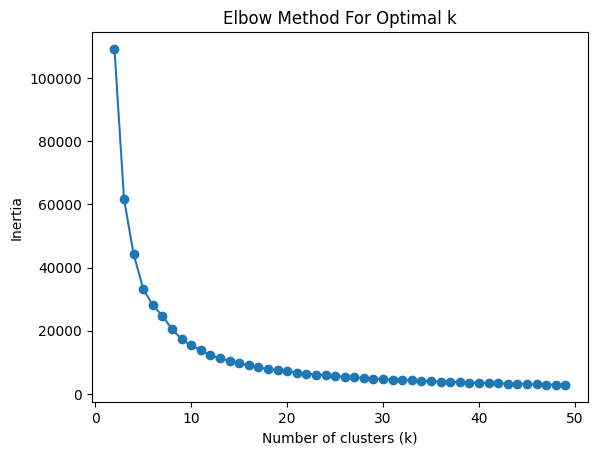

In [13]:
inertia = []
k_range = range(2, 50)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_emb)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### Now it's getting really interesting

UMAP preserves local structure, so we can see the clusters of words that are similar to each other.

For instance, "quantum, energies, many, body, particle" are all in the same cluster and same for "adam, semantic, overfitting, transformer, decoders, algorithms, scalable, training". 

we can confortably say that our classifier learned a coherent representation of the words in the embedding space and UMAP is a great tool to visualize it.

### Let's do the same for the titles

In [14]:
# a title is a sequence of words 
# the sequence is averaged along the temporal axis to create an embedding of the same size as a word
# i.e pooling avg 

# let's embed the titles 
# first we need to retrieve them using the dataloader 
from torch.nn.utils.rnn import pad_sequence

def custom_collate(batch, pad_value=0):
    sequences, labels = zip(*batch)
    # Padding sequences to obtain tensors of uniform size
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=pad_value)
    labels = torch.tensor(labels)
    return padded_sequences, labels

dataloader = DataLoader(dataset_mlp_cat_title, batch_size=64, collate_fn=custom_collate, shuffle=False)

# useless but wanted to remind myself how do dataloaders work
for batch, (padded_sequences, labels) in enumerate(dataloader): 
    for t, (seq, label) in enumerate(zip(padded_sequences, labels)):
        title = [dataset_mlp_cat_title.index_to_word[seq[i].item()] for i in range(len(seq)) if seq[i].item() != 0]
        cat = dataset_mlp_cat_title.index_to_class[label.item()]
        print(title, cat)
    break

['coexistence', 'of', 'distinct', 'mobility', 'edges', 'in', 'a', '1d', 'quasiperiodic', 'mosaic', 'model'] cond-mat
['beyond', 'disorder', 'unveiling', 'in', 'multidirectional', 'associative', 'memories'] cond-mat
['on', 'the', 'nature', 'of', 'the', 'glass', 'transition', 'in', 'metallic', 'glasses', 'after', 'deep', 'relaxation'] cond-mat
['relationship', 'between', 'the', 'shear', 'moduli', 'and', 'defect', 'induced', 'structural', 'relaxation', 'entropy', 'metallic', 'glasses'] cond-mat
['machine', 'learning', 'enhanced', 'calculation', 'of', 'quantum', 'classical', 'binding', 'free', 'energies'] physics
['hierarchical', 'quantum', 'embedding', 'by', 'machine', 'learning', 'for', 'large', 'molecular', 'assemblies'] physics
['many', 'body', 'localization', 'and', 'particle', 'statistics', 'in', 'disordered', 'bose', 'hubbard', 'model'] cond-mat
['interaction', 'correlated', 'random', 'matrices'] cond-mat
['critical', 'dynamics', 'in', 'short', 'range', 'quadratic', 'hamiltonians'] 

In [15]:
# we now use the dataloader to embed the titles using batches (bc the dataset is way too big)
def embed_all_titles_in_batches():
    model_mlp_cat_title.eval()
    all_emb = []

    with torch.no_grad():
        for padded_sequences, _ in dataloader:
            # we use the forward code 
            emb = model_mlp_cat_title.embedding(padded_sequences)  # [total_titles, seq_len, embedding_dim]
            mask = (padded_sequences != 0).unsqueeze(-1).float()
            emb = emb * mask
            sum_emb = emb.sum(dim=1)
            lengths = mask.sum(dim=1)
            avg_emb = sum_emb / lengths.clamp(min=1)  # [total_titles, embedding_dim]
            all_emb.append(avg_emb.cpu())

    return torch.cat(all_emb, dim=0)

emb_titles = embed_all_titles_in_batches()

In [16]:
emb_titles.shape # [total_titles, emb_dim]

torch.Size([1232614, 128])

In [17]:
# now that we have our embedded titles, we can reproduce what we did for the words 

# let's skip the PCA and directly plot the UMAP 
# We randomly sample 300000 titles
sample_size = 300000
indices = np.random.choice(emb_titles.shape[0], sample_size, replace=False)
emb_titles = emb_titles[indices]

reducer_titles = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=4)
umap_emb_titles = reducer_titles.fit_transform(emb_titles.cpu().numpy())

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
# as it takes approximatly 45min to perform the UMAP, we save it in a csv file
#df = pd.DataFrame(umap_emb_titles)
#df.to_csv("umap_mlp_title_cat.csv", index=False)

In [19]:
#umap = pd.read_csv('embedding_umap.csv')

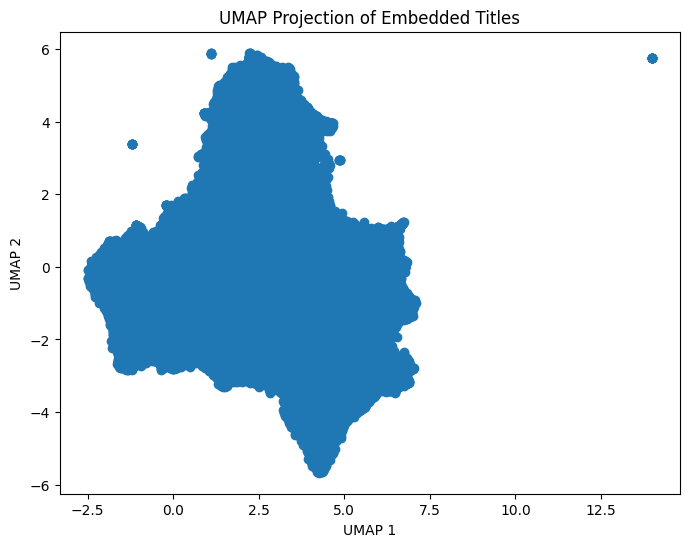

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_emb_titles[:, 0], umap_emb_titles[:, 1],
)
plt.title("UMAP Projection of Embedded Titles")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [21]:
n_clusters = 20
kmeans_titles = KMeans(n_clusters=n_clusters, random_state=42)

In [22]:
clusters_titles = kmeans_titles.fit_predict(umap_emb_titles)

c:\Users\cheri\nsi\M1\Arxiv-ML\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


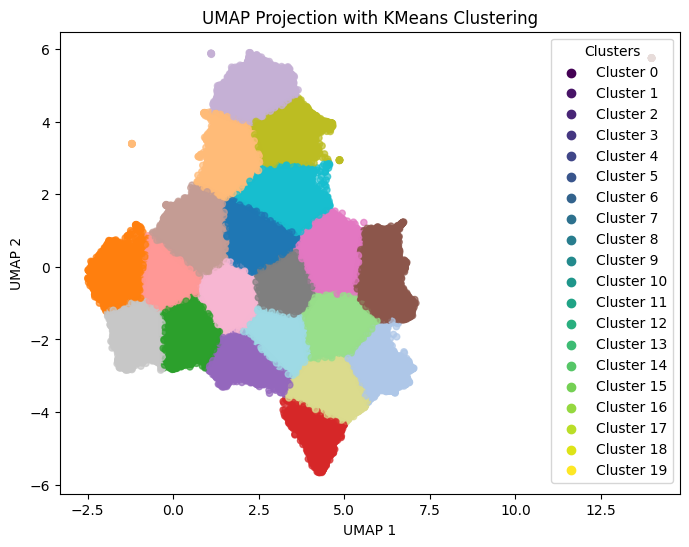

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_emb_titles[:, 0], umap_emb_titles[:, 1],
    c=clusters_titles,
    cmap=cmap,
    vmin=0,
    vmax=n_clusters-1,
    s=20,
    alpha=0.7
)
plt.title("UMAP Projection with KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
unique_clusters = np.unique(clusters_titles)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for i, uc in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f"Cluster {uc}")
plt.legend(title="Clusters")
plt.show()

In [53]:
# We can retrieve an embedded title from it's position in umap or emb_titles
# Indeed, the dataloader is intialized with shuffle = False, so each index in emb_titles corresponds to the index in dataset.data
# Let's test this
idxs = dataset_mlp_cat_title.data.index
idx = np.random.choice(idxs)
t_str = dataset_mlp_cat_title.data.iloc[idx].title
t_seq = dataset_mlp_cat_title[idx]
print(f"The title is : {t_str}")
print(f"it's tokenize representation is {t_seq}")

# Now, we must check if the embedded title at this location is the same
emb = model_mlp_cat_title.embedding(t_seq[0])  
sum_emb = emb.sum(dim=0)     
lengths = len(t_seq[0])   
avg_emb = sum_emb / lengths
avg_emb
dists = torch.norm(emb_titles - avg_emb, dim=1)
min_index = torch.argmin(dists)
print(f"closest index in emb_titles {min_index.item()} index in the dataset {idx}")
print(f'the distance is {torch.min(dists)}')
# It works !!
# dist is 0 i.e they are equal
# If the dist is not 0, it's because we only have a sample of 300000 titles

The title is : Logical Modalities within the European AI Act: An Analysis
it's tokenize representation is (tensor([ 2803, 11796,  2203,    19,  6865,   479,  7097,   177,   107]), tensor(4))
closest index in emb_titles 272357 index in the dataset 924866
the distance is 0.0


In [57]:
# Pour chaque cluster, on affiche 10 titres aléatoires avec leur catégorie réelle et prédite
with torch.no_grad():
    for cl in unique_clusters:
        idxs_cl = np.where(clusters_titles == cl)[0]
        # Sélectionner 10 indices aléatoires dans ce cluster
        random_indices = np.random.choice(idxs_cl, min(10, len(idxs_cl)), replace=False)
        
        print(f"Cluster {cl}:")
        for idx in random_indices:
            # titre
            title = dataset_mlp_cat_title.data.iloc[sample_indices[idx]].title.replace("\n", "")
            # séquence et label
            seq, true_label = dataset_mlp_cat_title[sample_indices[idx]]
            # prédiction
            logits = model_mlp_cat_title(seq.unsqueeze(0).to(device))
            pred_idx = logits.argmax(dim=1).item()
            # noms des catégories
            true_cat = dataset_mlp_cat_title.index_to_class[true_label.item()]
            pred_cat = dataset_mlp_cat_title.index_to_class[pred_idx]
            print(f"- {title}")
            print(f"  true : {true_cat}, pred : {pred_cat}")
        print()

Cluster 0:
- On full linear convergence and optimal complexity of adaptive FEM with  inexact solver
  true : math, pred : math
- Multiple Testing of Linear Forms for Noisy Matrix Completion
  true : stat, pred : cs
- Inverse problems in multifractal analysis
  true : math, pred : math
- Homogenization and Mean-Field Approximation for Multi-Player Games
  true : math, pred : math
- Spectrum of periodic chain graphs with time-reversal non-invariant  vertex coupling
  true : math-ph, pred : math
- Moment convergence of $Z$-estimators and $Z$-process method for change  point problems
  true : math, pred : math
- Distribution of Schmidt-like eigenvalues for Gaussian Ensembles of the  Random Matrix Theory
  true : cond-mat, pred : math
- Hopf bifurcation of a free boundary problem modeling tumor growth with  angiogenesis and two time delays
  true : math, pred : math
- An Introduction to Different Approaches to Initial Semantics
  true : cs, pred : cs
- Nonlinear Fourier transform and probab

In [26]:
from collections import Counter

for cl in unique_clusters:
    cluster_indices = np.where(clusters_titles == cl)[0]
    cats = [dataset_mlp_cat_title.index_to_class[dataset_mlp_cat_title[i][1].item()] for i in cluster_indices]
    count = Counter(cats)
    print(f"Cluster {cl}:")
    for cat, num in count.items():
        print(f"  {cat}: {num}")

Cluster 0:
  cond-mat: 2529
  q-bio: 117
  stat: 18
  hep-th: 175
  quant-ph: 376
  cs: 109
  physics: 1480
  hep-lat: 16
  nucl-th: 126
  math: 138
  nlin: 430
  q-fin: 293
  gr-qc: 213
  eess: 7
  hep-ph: 246
  astro-ph: 103
  math-ph: 79
  econ: 109
  hep-ex: 124
  nucl-ex: 183
Cluster 1:
  cond-mat: 3089
  cs: 149
  q-bio: 136
  quant-ph: 495
  nucl-th: 147
  math: 149
  physics: 1701
  q-fin: 332
  hep-lat: 14
  nlin: 547
  stat: 34
  math-ph: 110
  eess: 16
  hep-th: 205
  astro-ph: 153
  nucl-ex: 226
  gr-qc: 216
  hep-ph: 251
  econ: 117
  hep-ex: 143
Cluster 2:
  hep-th: 451
  cond-mat: 7632
  cs: 324
  stat: 58
  physics: 4579
  quant-ph: 1144
  astro-ph: 358
  nlin: 1326
  q-bio: 286
  hep-lat: 55
  math: 385
  math-ph: 244
  eess: 28
  q-fin: 839
  nucl-th: 403
  hep-ph: 735
  gr-qc: 614
  hep-ex: 369
  nucl-ex: 506
  econ: 285
Cluster 3:
  cond-mat: 7344
  math: 333
  cs: 299
  q-bio: 292
  quant-ph: 1080
  physics: 4233
  stat: 70
  hep-lat: 44
  hep-th: 490
  nlin: 1210


In [56]:
print("Proportions dans chaque cluster, par ordre décroissant :")
for cl in unique_clusters:
    # indices des titres dans ce cluster
    idxs_cl = np.where(clusters_titles == cl)[0]
    # récupération des catégories réelles (indices dans l'échantillon)
    cats_cl = [dataset_mlp_cat_title.index_to_class[dataset_mlp_cat_title[sample_indices[i]][1].item()] for i in idxs_cl]
    count_cl = Counter(cats_cl)
    total_cl = sum(count_cl.values())
    
    print(f"\nCluster {cl} (taille: {total_cl} articles):")
    
    # Trier les catégories par nombre d'occurrences décroissant
    sorted_cats = sorted(count_cl.items(), key=lambda x: x[1], reverse=True)
    
    for cat, num in sorted_cats:
        prop_cl = num / total_cl
        print(f"  {cat}: {num} articles - {prop_cl:.2%}")

Proportions dans chaque cluster, par ordre décroissant :

Cluster 0 (taille: 6871 articles):
  math: 3460 articles - 50.36%
  cs: 1111 articles - 16.17%
  physics: 580 articles - 8.44%
  stat: 558 articles - 8.12%
  cond-mat: 258 articles - 3.75%
  nlin: 182 articles - 2.65%
  eess: 133 articles - 1.94%
  q-bio: 118 articles - 1.72%
  q-fin: 113 articles - 1.64%
  math-ph: 107 articles - 1.56%
  quant-ph: 71 articles - 1.03%
  econ: 58 articles - 0.84%
  astro-ph: 47 articles - 0.68%
  hep-th: 29 articles - 0.42%
  gr-qc: 15 articles - 0.22%
  hep-lat: 11 articles - 0.16%
  hep-ph: 9 articles - 0.13%
  nucl-th: 5 articles - 0.07%
  hep-ex: 3 articles - 0.04%
  nucl-ex: 3 articles - 0.04%

Cluster 1 (taille: 8230 articles):
  hep-ph: 2415 articles - 29.34%
  nucl-th: 1648 articles - 20.02%
  nucl-ex: 1502 articles - 18.25%
  hep-ex: 1056 articles - 12.83%
  physics: 675 articles - 8.20%
  hep-lat: 513 articles - 6.23%
  astro-ph: 134 articles - 1.63%
  hep-th: 108 articles - 1.31%
  con

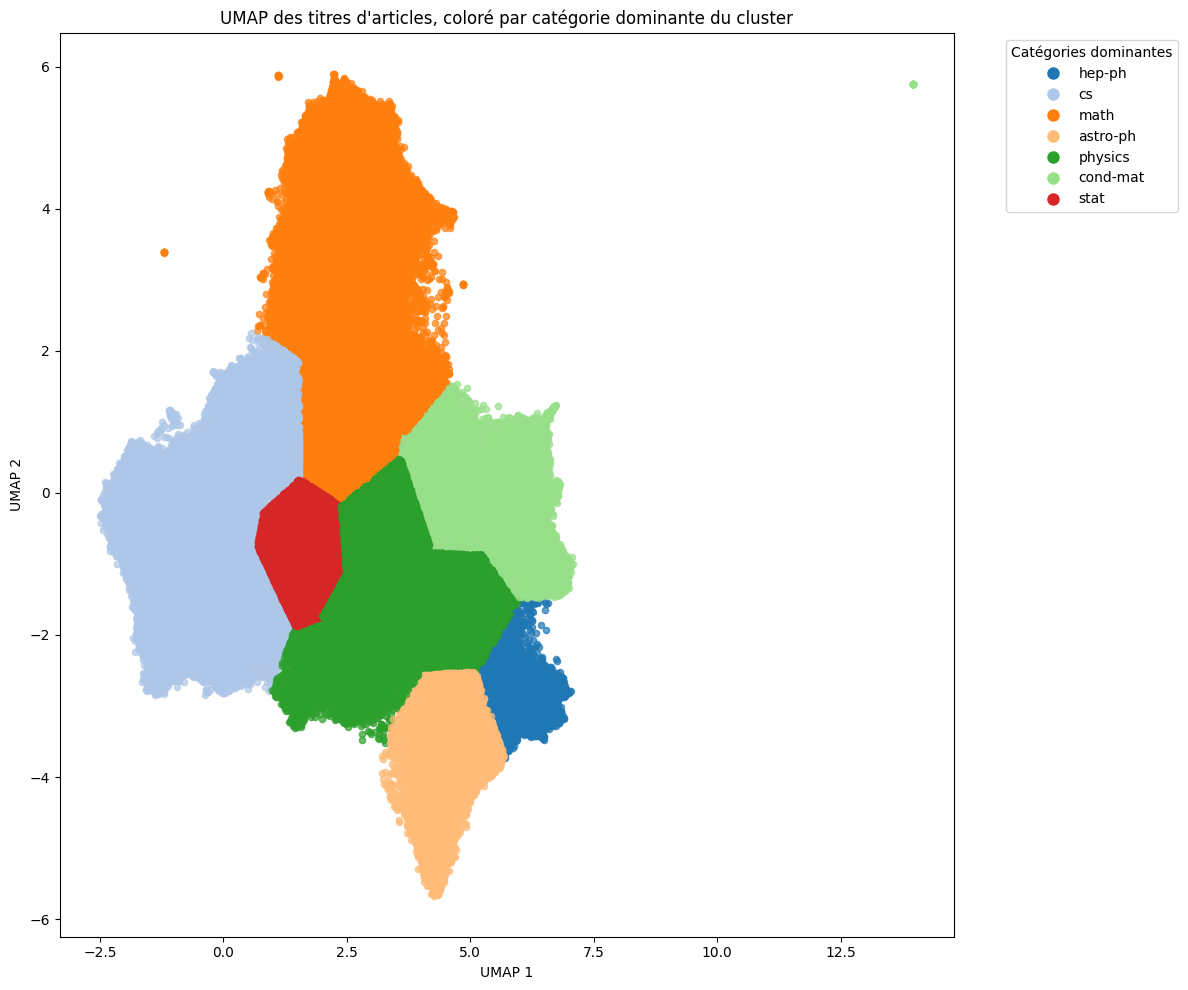

In [ ]:
# Visualiser les clusters avec leurs catégories dominantes
plt.figure(figsize=(12, 10))

# Créer un dictionnaire de clusters et leurs catégories dominantes
cluster_categories = {}
for cl in unique_clusters:
    idxs_cl = np.where(clusters_titles == cl)[0]
    cats_cl = [dataset_mlp_cat_title.index_to_class[dataset_mlp_cat_title[sample_indices[i]][1].item()] for i in idxs_cl]
    count_cl = Counter(cats_cl)
    dominant_cat = count_cl.most_common(1)[0][0] if count_cl else "Unknown"
    cluster_categories[cl] = dominant_cat

# Créer un mapping des catégories à des couleurs
unique_categories = set(cluster_categories.values())
cat_color_map = {cat: plt.cm.tab20(i % 20) for i, cat in enumerate(unique_categories)}

# Scatter plot avec couleurs basées sur la catégorie dominante
for cl in unique_clusters:
    idxs_cl = np.where(clusters_titles == cl)[0]
    dominant_cat = cluster_categories[cl]
    plt.scatter(
        umap_emb_titles[idxs_cl, 0], 
        umap_emb_titles[idxs_cl, 1],
        color=cat_color_map[dominant_cat],
        label=f"{dominant_cat} (Cluster {cl})",
        alpha=0.7,
        s=20
    )

# Ajouter titre et légende
plt.title("UMAP des titres d'articles, coloré par catégorie dominante du cluster")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Créer une légende personnalisée pour éviter les duplications
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cat_color_map[cat], 
                     markersize=10, label=cat) for cat in unique_categories]
plt.legend(handles=handles, title="Catégories dominantes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()